In [1]:
#importation des bibiotheque necessaire
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
np.set_printoptions(precision=2, linewidth=80)
from nltk import FreqDist
# Gensim
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
#from bs4 import BeautifulSoup
import unicodedata

from spacy.lang.fr.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

spacy.load('fr_core_news_md')
import fr_core_news_md #import spacy french stemmer
from sklearn.decomposition import NMF,LatentDirichletAllocation

import pyLDAvis #Nous utilisons pyLDAvis pour créer des visualisations interactives de modèles de sujet.
import pyLDAvis.sklearn

#dealing with date
import dateparser

import datetime

In [2]:
data_set1=pd.read_csv("Article19.csv")
data_set2=pd.read_csv("aujourdhui.csv")
data_set3=pd.read_csv("bladi.csv")
data_set4=pd.read_csv("challenge.csv")
data_set4.drop("link",axis=1,inplace=True)
data_set5=pd.read_csv("H24info.csv")
data_set5.drop("link",axis=1,inplace=True)
data_set6=pd.read_csv("lesiteinfo.csv")
data_set7=pd.read_csv("mapnews.csv")
data_set8=pd.read_csv("marochebdo.csv")
data_set9=pd.read_csv("media24.csv")
data_set10=pd.read_csv("telquel.csv")
data_set11=pd.read_csv("le360.csv")
data_set12=pd.read_csv("laquotidien.csv")
datasets = [data_set1,data_set2,data_set3,data_set4,data_set5,data_set6,
    data_set7,data_set8,data_set9,data_set10,data_set11,data_set12]

In [3]:
for dataset in datasets :
    print(dataset.columns , np.shape(dataset))

Index(['titre', 'date', 'extrait'], dtype='object') (4162, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (19035, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (85188, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (528, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (3999, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (7812, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (5584, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (3120, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (11162, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (4860, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (21315, 3)
Index(['titre', 'date', 'extrait'], dtype='object') (9189, 3)


In [4]:
whole_data_set= pd.concat(datasets)

In [5]:
whole_data_set.head()

,titre,date,extrait
0,"Transport – Royal Air Maroc, première compagni...",30/05/2022,"Le transporteur national, Royal Air Maroc (RAM..."
1,Innovation – Maroc: 10 lauréats désignés lors ...,28/05/2022,"Au Maroc, 10 lauréats ont été désignés lors de..."
2,Classement – Tanger Med en 6è position dans la...,28/05/2022,Le Port de Tanger Med a été classé en 6è posit...
3,"Logistics – Après deux années d’absence, Logis...",28/05/2022,La 9ème édition du Salon international du tran...
4,Coopération – Treize MoU d’entente portant sur...,26/05/2022,Les travaux du Forum « Morocco-Israel: Connect...


In [6]:
np.shape(whole_data_set)

(175954, 3)

In [7]:
lexique=["bitcoin"]

In [8]:
#output French accents correctly
def convert_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')

In [9]:
#convertisse les documents en minuscule
def lower_text(corpus):
    LowerCorpus=[]
    for doc in corpus:
        lowerDoc=str(doc).lower() #convertissent le texte en minuscules
        lowerDoc=convert_accents(lowerDoc).decode("utf-8") #supprimes les accents
        LowerCorpus.append(lowerDoc)
    return LowerCorpus

In [10]:
def remove_characters(corpus,keep_apostrophes=True):
    filtered_corpus=[]
    for doc in corpus:
        doc = doc.strip()
        if keep_apostrophes:
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            PATTERN = r'[?|$|&|*|%|@|(|)|~|\d]'
            filtered_doc = re.sub(PATTERN, r'', doc)
            filtered_corpus.append(filtered_doc)
        else:
            PATTERN = r'[^a-zA-Z ]'
            #supprimes les urls
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            filtered_doc = re.sub(PATTERN, r'', doc)
        
            filtered_corpus.append(filtered_doc)
    return filtered_corpus

<>:6: DeprecationWarning: invalid escape sequence \S
<>:13: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<>:13: DeprecationWarning: invalid escape sequence \S
C:\Users\ORIGIN~1\AppData\Local\Temp/ipykernel_11112/554940301.py:6: DeprecationWarning: invalid escape sequence \S
  doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
C:\Users\ORIGIN~1\AppData\Local\Temp/ipykernel_11112/554940301.py:13: DeprecationWarning: invalid escape sequence \S
  doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls


In [11]:
#Tokenization
def tokenize_text(corpus):
    tokensCorpus=[]
    for doc in corpus:
        doc_tokens = word_tokenize(doc)
        tokensCorpus.append(doc_tokens)
    return tokensCorpus

In [12]:
#recuperer les mots qui apparaissent dans plusieurs documents
def get_mostCommonWords(corpus,max_freq=100):
    vocabulaire=dict() #dictionnaire qui va contenir le nombre d'occurence des mots dans les documents
    for doc in corpus:
        for word in set(doc.split()): #recupere les mots unique de chaque documents
            if word in vocabulaire:
                vocabulaire[word]+=1
            else:
                vocabulaire[word]=1
    
    #recupere les dont le nombre d'occurences dans les documents > max_freq
    mostCommonsWord=[word for word,value in vocabulaire.items() if value>max_freq ]
        
    return mostCommonsWord

In [13]:
# removing stopwords
def remove_stopwords(corpus,mostCommonsWord):
    filtered_corpus=[]
    for tokens in corpus:
        others_sw=["maroc","morocco","marocain","marocaine","marocains","marocaines","maghreb","météorologique","journée",
                   "méteo","retweet","newspic","twitter","com","pic","newspic","illustration"]
        
        #french_sw = stopwords.words('french') 
        french_sw=list(STOP_WORDS) #get french stopwords
        french_sw.extend(others_sw)
        french_sw.extend(mostCommonsWord)
        
        filtered_tokens = [token for token in tokens.split() if token not in french_sw and len(token)>2]
        filtred_text=' '.join(filtered_tokens) #reforme le text du documents separé par espace
        filtered_corpus.append(filtred_text)
    return filtered_corpus

In [14]:
#lemmatisation
def lemm_tokens(corpus):
    
    nlp = fr_core_news_md.load() #initialisation du model "fr_core_news_md" de spacy
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    corpus_lemms=[]
    
    idx_doc=[] #liste qui va stocker les indices documents qui seront dans le corpus
    for idx,document in enumerate(corpus):
        doc = nlp(document)
        lemms=[token.lemma_ for token in doc if token.pos_ in allowed_postags] #recupere les lemms des tokens
        
        if len(lemms)>5: #supprime les document qui ne contient pas plus de 2 mots
            text=' '.join(lemms) #reforme le text du documents separé par espace
            corpus_lemms.append(text)
            idx_doc.append(idx) #ajoute l'indice du documents
            
    return corpus_lemms,idx_doc

In [15]:
#fonction qui supprimes les documents vides ou tres courte
def remove_shortDocument(corpus,min_length=3):
    filtred_corpus=[]
    idx_doc=[]
    for idx,doc in enumerate(corpus):
        
        if len(doc.split())>min_length:
            filtred_corpus.append(doc)
            idx_doc.append(idx)
        
    
    return filtred_corpus,idx_doc

In [16]:
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=2, threshold=10) # higher threshold fewer phrases
    # Un moyen plus rapide d'obtenir une phrase matraquée comme un trigramme / bigramme
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    corpus_bigram=[" ".join(bigram_mod[doc]) for doc in texts]
    return corpus_bigram

In [17]:
def preprocessing(corpus):
    
    corpus=lower_text(corpus)
    corpus=remove_characters(corpus)
    corpus=tokenize_text(corpus)
    #corpus=remove_mostCommonWords(corpus,max_freq=20)
    corpus=remove_stopwords(corpus)
    corpus,idx_docs=lemm_tokens(corpus)
    
    
    return corpus,idx_docs

In [18]:
corpus = whole_data_set.extrait.values.tolist()
print("Taille du corpus = "+str(len(corpus))+" Documents")

Taille du corpus = 175954 Documents


In [19]:
corpus=lower_text(corpus)

In [20]:
most_commonWords=get_mostCommonWords(corpus,500) #recupere les mots qui apparaisent dans plusieurs document
print("Nombre de mots tres frequents = "+str(len(most_commonWords))+" Mots")

Nombre de mots tres frequents = 1426 Mots


In [21]:
corpus=remove_stopwords(corpus,most_commonWords)#supprimes les mots les plus frequents,les stop words et qlq mots inutiles
corpus,idx_doc=remove_shortDocument(corpus,min_length=3) #supprimes les documents vides
print("Nouvelle Taille du corpus = "+str(len(corpus))+" Documents")

Nouvelle Taille du corpus = 159300 Documents


# TF-IDF

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Original
[nltk_data]     Shop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
#build TFIDF features on train reviews with a specifique vocabulary
corpus_lemmatized=tokenize_text(corpus) 
id2word = corpora.Dictionary(corpus_lemmatized)
vocabulaire=id2word.token2id #get vocabulary dict where keys are terms and values are indices in the feature matrix

tfidf = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0,sublinear_tf=True,lowercase=True,ngram_range=(1,2),vocabulary=vocabulaire)
tfidf_train_features = tfidf.fit_transform(corpus)

# Construction du modèle de sujet:
Le modèle est construit avec 10 sujets initiaux où chaque sujet est une combinaison de mots-clés et chaque mot-clé contribue à un certain poids au sujet.

In [24]:
total_topics = 10 #nombre de topics
pos_nmf=NMF(n_components=total_topics,random_state=42,l1_ratio=0.2,max_iter=200)
pos_nmf.fit(tfidf_train_features) 

C:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(l1_ratio=0.2, n_components=10, random_state=42)

# Affichage des sujets

In [25]:
# extractions des features et des poids
pos_feature_names = tfidf.get_feature_names()
pos_weights = pos_nmf.components_

In [26]:
# extracts topics with their terms and weights
# format is Topic N: [(term1, weight1), ..., (termn, weightn)]        
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    
    #trie les indices des mots de chaque topics selon la poids du mots dans le topics
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    
    #trie les poids des mots de chaques topics,en recuperant les poids des indices deja triée
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights,sorted_indices)])
    
    #recupres les mots selon leurs indices deja triée
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    
    #concatene chaque mots et sa poids sous formes de tuple (mot,poids)
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]     
    
    return topics


# prints components of all the topics 
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,weight_threshold=0.0001,display_weights=False,num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt)) for term, wt in topic] #recupere les mots et les poids du topic
        
        #seuillage des mots selon le seuil de poids definie
        topic = [(word, round(wt,2)) for word, wt in topic if abs(wt) >= weight_threshold]
        
        #affiches les "num_terms" de chaque topics
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
        print()

In [27]:
# extract and display topics and their components
pos_topics = get_topics_terms_weights(pos_weights, pos_feature_names)
print_topics_udf(topics=pos_topics,total_topics=total_topics,num_terms=15,display_weights=True)

Topic #1 with weights
[('000', 5.68), ('100', 0.63), ('200', 0.55), ('500', 0.5), ('10', 0.47), ('produire', 0.43), ('20', 0.4), ('crees', 0.4), ('400', 0.4), ('emplois', 0.35), ('milieu', 0.34), ('an', 0.3), ('peugeot', 0.3), ('50', 0.28), ('30', 0.28)]

Topic #2 with weights
[('al', 2.45), ('maghrib', 1.65), ('tetouan', 0.99), ('tanger', 0.85), ('hoceima', 0.47), ('jouahri', 0.46), ('adha', 0.18), ('bank', 0.14), ('enregistrer', 0.13), ('aid', 0.13), ('gouverneur', 0.12), ('malaga', 0.11), ('med', 0.11), ('setablir', 0.1), ('monetaires', 0.1)]

Topic #3 with weights
[('covid', 1.23), ('19', 1.19), ('il', 0.66), ('mmdh', 0.54), ('qu', 0.53), ('post', 0.47), ('benchaaboun', 0.47), ('fes', 0.47), ('2020', 0.46), ('lartisanat', 0.46), ('mdh', 0.45), ('meknes', 0.45), ('entreprises', 0.44), ('plf', 0.43), ('interieur', 0.43)]

Topic #4 with weights
[('fonciere', 1.69), ('conservation', 1.65), ('cadastre', 1.54), ('cartographie', 1.52), ('ancfcc', 1.32), ('ipai', 0.43), ('il', 0.36), ('imm

# Calcul de la cohérence du modèle :
La cohérence des sujets constituent une mesure pratique pour juger de la qualité d'un modèle de sujet,ici on utilise La Coherence UMass qu'on a implementé nous meme.

In [28]:
def getTopicTerms(pos_topics):
    """
    Fonction qui retourne l'ensemble des mots qui compose chaque topics
    ----Input----
    pos_topics: ensemble des topics qui contients les mots et leurs poids
    ---output---
    topic_terms : ensemble des mots des topics
    
    """
    topic_terms=[]
    for topic in pos_topics:
        #topic=topic[:max_term] #recupere les "max_term" premiere mots et leurs poids
        terms=[]
        for doc in topic:
            terms.append(doc[0]) #recupere justes les mots sans les poids
        
        topic_terms.append(terms) #ajoute l'ensemble des mots
    
    return topic_terms

In [29]:
topic_terms=getTopicTerms(pos_topics) #recupere les mot des de chaque topics

topic_terms=[topics[:20] for topics in topic_terms] #recupere les termes avec les plus grandes poids
# Term Document Frequency
common_corpus = [id2word.doc2bow(text) for text in corpus_lemmatized]

cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, coherence='u_mass')
coherence = cm.get_coherence()
print("Coherence = ", coherence)

Coherence =  -13.37792009885769


# Trouver le nombre de sujets optimal :
Pour trouver le nombre de sujets optimal est de construire de nombreux modèles avec différentes valeurs de nombre de sujets k et de choisir celui qui donne la valeur de cohérence UMass la plus élevée

In [30]:
def compute_coherence_values(tfidf_train_features,feature_names,corpus,data_lemmatized,id2word,max_term=20,limit=50, start=5, step=5):
    """
    Calcul la coherence UMass pour different nombre de topic
    
    Parameters:
    ----------
    tfidf_train_features : features tf-idf qu'on va utiliser pour entrainer chaque model
    feature_names : ensemble des mots contenue dans la matrice tf-idf
    corpus: corpus de base qui contients les documents sous forme de texte
    max_term: nombre maximal de mots qu'on va prendre pour calculé la coherence de chaque topic
    data_lemmatized: corpus sous forme de tokens
    id2word:vocabulaire du corpus au format de gensim
    max_term:le nombre de termes qu'on va prendre dans chaque topic pour calculer la Coherence
    limit : Nombre maximal de topics qu'on va tester

    Returns:
    -------
    best_model : le model qui contient le plus grande coherence
    coherence_values : Valeurs des Cohérences correspondant au modèle avec le nombre respectif de sujets
    """
    
    
    model_list = [] #listes qui va contenir les modeles tester
    coherence_values = [] #liste qui contenir les coherences de chaque models
    # Term Document Frequency
    
    common_corpus = [id2word.doc2bow(text) for text in data_lemmatized] #recupere la matrice bog of word du corpus sous le format de gensim
   
    #print(coherence)
    for num_topics in range(start, limit, step):
        
        model=NMF(n_components=num_topics,random_state=42) #model MNF
        model.fit(tfidf_train_features)
        weights = model.components_ #recupere les poids
        
        model_list.append(model) #ajoute le model la liste des models utilisé
        
        
        topics=get_topics_terms_weights(weights,feature_names)
        
        topic_terms=getTopicTerms(topics)#recupere les mot des de chaque topics
        
        topic_terms=[topics[:max_term] for topics in topic_terms] #recupere les  "max_term" termes avec les plus grandes poids
        
        #calcule du Coherence UMass
        cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, coherence='u_mass')
        coherence = cm.get_coherence()
        coherence_values.append(coherence)
    
    idx_max=np.array(coherence_values).argmax() #recupere l'indice du model qui possede le plus grands coherence
    best_model=model_list[idx_max] #recupere le meilleur models
    

    return best_model,coherence_values

In [31]:
best_model,coherence_values=compute_coherence_values(tfidf_train_features,pos_feature_names,
                                                     corpus,corpus_lemmatized,id2word,max_term=20,limit=50)

C:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Original Shop\anaconda3\lib\

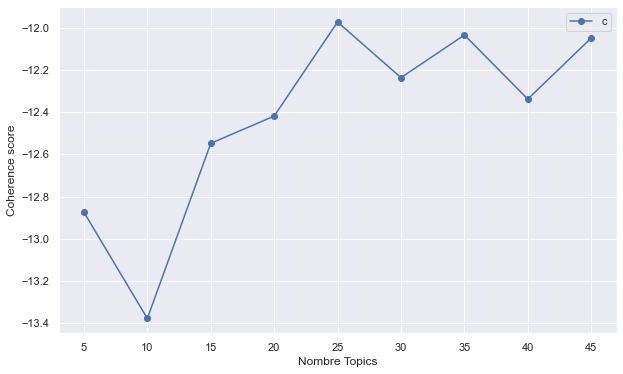

In [32]:
# Show graph
import seaborn as sns
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x,np.array(coherence_values),marker="o")
plt.xlabel("Nombre Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
total_topics=best_model.n_components #recupere le nombre de topics du meilleurs modeles
weights = best_model.components_ #recuperes les poids du meilleurs modeles
# extract features and component weights
feature_names = tfidf.get_feature_names()

print("Le nombre de topic optimal est : ",total_topics)
print("*"*100)
topics = get_topics_terms_weights(weights,feature_names)
print_topics_udf(topics,total_topics,num_terms=15,display_weights=False)

Le nombre de topic optimal est :  25
****************************************************************************************************
Topic #1 without weights
['000', '100', '200', '500', '10', 'produire', '400', 'crees', '20', 'emplois', 'milieu', 'an', '50', '30', 'chomeurs']

Topic #2 without weights
['al', 'maghrib', 'jouahri', 'adha', 'bank', 'enregistrer', 'gouverneur', 'bam', 'aid', 'setablir', 'monetaires', '42', '39', 'ipai', 'flexibilite']

Topic #3 without weights
['il', 'mmdh', 'qu', 'benchaaboun', 'plf', 'interieur', '2020', 'pib', 'entreprises', 'economie', '2021', 'administration', 'entrepreneurs', 'cgem', 'subventions']

Topic #4 without weights
['fonciere', 'conservation', 'cadastre', 'cartographie', 'ancfcc', 'ipai', 'immobilieres', 'il', 'est', 'trimestre', 'glissement', 'annuel', 'bam', 'acheter', 'baisse']

Topic #5 without weights
['indice', '12', '13', 'pts', 'points', 'masi', 'hausse', 'gagnant', 'prenant', 'principal', '11', 'evoluait', 'baisse', 'echanges'

In [34]:
# Visualize the topics
pyLDAvis.sklearn.prepare(best_model,tfidf_train_features, tfidf, R=15)

C:\Users\Original Shop\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.016702  0.028483       1        1  25.875630
17    -0.138475 -0.015775       2        1   6.111978
22    -0.116999 -0.146132       3        1   4.910840
21    -0.107763  0.175117       4        1   4.197849
7     -0.127562 -0.051119       5        1   4.151991
23    -0.068412 -0.202332       6        1   4.035208
20    -0.040518 -0.071512       7        1   3.564484
19     0.026608 -0.011754       8        1   3.449810
4      0.281645  0.066596       9        1   3.362874
9      0.059047  0.030584      10        1   3.268776
16    -0.002811 -0.020176      11        1   3.039118
0      0.029010  0.146285      12        1   2.981216
13    -0.052758 -0.048513      13        1   2.962579
15    -0.062346  0.040256      14        1   2.882459
18    -0.097223  0.134450      15        1   2.807623
14    -0.087769  0.200909      16        1   2.7477

# Trouver le sujet dominant dans chaque document :
Pour trouver cela,il suffit de trouver le numéro de topic qui a le pourcentage de contribution le plus élevé dans ce document

In [35]:
def topic_dominant(model,tdidf_features,corpus,topics):
    
    #document topic distribution :la probabilité des topics pour chaque document
    doc_topic_dist = model.transform(tdidf_features) 
    
    topic_num=[] #liste qui contenir le numero du topic dominant dans chaque documents
    probs_topics=[] #liste qui va contenir les probabilités du topic dominant dans chaque documents
    topic_keywords=[] #liste qui contenir les 5 termes les plus representative du sujet
    text_doc=[] #liste qui va contenir le texte de chaque documents
    
    topic_terms=getTopicTerms(topics) #recupere les mot de chaque topics
    
    num_doc=[]
    
    for i,doc in enumerate(doc_topic_dist):
        text_doc.append(corpus[i]) #recupere le texte du documents
        num_doc.append(i+1) #recupere le numero du documents
        
        idx_max=doc.argmax() #recupere l'indice du topic qui a de la probabilité maximal
        topic_num.append(idx_max) 
        probs_topics.append(round(doc.max(),4)) #recupere la probabilité maximal arrondis
        
        kw=",".join(topic_terms[idx_max][:5]) #recupere les mots clé du topic
        topic_keywords.append(kw)
        
    
    sent_topics_df = pd.DataFrame([num_doc,topic_num,probs_topics,topic_keywords,text_doc]).T
    sent_topics_df.columns=["Num Document","Topic Dominant","Contrib Topic","Key Word","Text"]
    
    return sent_topics_df

In [36]:
sent_topics_df=topic_dominant(best_model,tfidf_train_features,corpus,topics)
sent_topics_df.sample(20)

,Num Document,Topic Dominant,Contrib Topic,Key Word,Text
51873,51874,2,0.0023,"il,mmdh,qu,benchaaboun,plf",dur opposees autorises lhexagone
149046,149047,13,0.0033,"sdx,forage,decouverte,puits,petroliere","175 dirigeants prives attendus 4eme (amic),"
97309,97310,2,0.0067,"il,mmdh,qu,benchaaboun,plf",80% petites moyennes algerie touchees lie
151172,151173,23,0.0086,"fiscaux,paradis,grise,lue,bruxelles","mediatique, salue resilience reactivite preuve..."
144749,144750,2,0.0035,"il,mmdh,qu,benchaaboun,plf",beneficiaire inscrites amelioree marges benefi...
158453,158454,16,0.0116,"forbes,milliardaires,riches,hommes,figurent",lafarge decline axes revenant realisations 201...
63309,63310,2,0.0049,"il,mmdh,qu,benchaaboun,plf","faillite imminente communes militants pjd, dif..."
2307,2308,4,0.0103,"indice,12,13,pts,points","778 11,45 approuves (cri) loriental"
11227,11228,16,0.0084,"forbes,milliardaires,riches,hommes,figurent",fidele engagement proposer innovations moment ...
104719,104720,2,0.0044,"il,mmdh,qu,benchaaboun,plf","present mfadel, reference limmobilier, optique..."


# Trouvez le document le plus représentatif pour chaque sujet :
Parfois, seuls les mots-clés du sujet peuvent ne pas être suffisants pour donner un sens au sujet d'un sujet. Donc, pour vous aider à comprendre le sujet, vous pouvez trouver les documents auxquels un sujet donné a le plus contribué et en déduire le sujet en lisant ce document

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd =sent_topics_df.groupby('Topic Dominant')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted= pd.concat([sent_topics_sorted, grp.sort_values(['Contrib Topic'], ascending=[0]).head(1)], 
                                    axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted=sent_topics_sorted.drop(["Num Document"],axis=1)
# Show
sent_topics_sorted.head(20)

,Topic Dominant,Contrib Topic,Key Word,Text
0,0,0.0585,"000,100,200,500,10",500.000 doubler (somaca) 160.000
1,1,0.2073,"al,maghrib,jouahri,adha,bank","3,1% enregistrer 3,1% 3,6% al-maghrib."
2,2,0.0351,"il,mmdh,qu,benchaaboun,plf","5,9 plf 72,6 (mmdh), 5,9 interieur (pib)."
3,3,0.27,"fonciere,conservation,cadastre,cartographie,an...","conservation fonciere, cadastre cartographie (..."
4,4,0.1999,"indice,12,13,pts,points","indice, gagnant 0,13% 12.671,13 points."
5,5,0.2254,"tui,fly,belgique,lille,ete",tui fly tui fly
6,6,0.166,"dollar,perd,leuro,monnaie,41","perd 0,4% 0,5% dollar,"
7,7,0.1202,"maroc,israel,nigeria,normalisation,france",l'initiative conjointe chambres d'industrie ma...
8,8,0.0862,"casablanca,settat,aviv,tel,dakhla","domestiques, frequences casablanca-dakhla casa..."
9,9,0.1505,"19,covid,post,masques,mdh",post-covid-19 debat post-covid-19 saadeddine o...


In [38]:
def format_date(date):
    return  dateparser.parse(str(date)).date()

whole_data_set["New_Date"] = whole_data_set["date"].apply(format_date)

C:\Users\Original Shop\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [39]:
whole_data_set.sample(7)

,titre,date,extrait,New_Date
30446,Maroc : les banques durcissent les conditions ...,2020-11-25,Maroc : les banques durcissent les conditions ...,2020-11-25
13815,COP22 : The round up,2016-11-21 13:49:06+01:00,"Proclamation de Marrakech, partenariat global ...",2016-11-21
16619,L’industrie de la gestion d’OPCVM souffle sa 2...,2015-05-22 00:00:00+01:00,L’Association des sociétés de gestion et fonds...,2015-05-22
1332,Le Roi Mohammed VI reçoit Elalamy et le PDG du...,25/10/2018,Le Roi Mohammed VI a reçu jeudi au Palais Roya...,2018-10-25
551,EEP : légère amélioration des délais de paieme...,2022-02-01,\nLa moyenne des délais de paiement déclarés p...,2022-02-01
5050,Covid-19. L’indemnité-chômage maintenue jusqu’...,07/08/2020,La décision de prolonger l’octroi de l’indemni...,2020-07-08
78063,Les Marocains du monde envoient en masse des d...,2016-05-25,Les Marocains du monde envoient en masse des d...,2016-05-25


In [40]:
#recupere les dates sous formes de datime,on cherche juste les documents dont les indices sont "idx_doc"
dates=pd.to_datetime((whole_data_set.iloc[idx_doc]["New_Date"].values)[:-2])

#dates=pd.to_datetime(dataset["date"].values)#recupere les dates sous formes de datime

#document topic distribution :la probabilité des topics pour chaque document
doc_topic_dist = best_model.transform(tfidf_train_features) 

labels=getTopicTerms(topics) #recupere les mots des topics
labels=[",".join(topic_term[:5]) for topic_term in labels] #recupere juste les 3 premieres mots

#formation 'un dataframe qui contient la date,le numero et le text de chaque documents
df=pd.DataFrame({"text":corpus[:-2],"Date":dates,"doc_num":np.arange(len(corpus)-2)})

stories=df.groupby("doc_num")["text","Date"].min().reset_index() #trie les articles selon les dates

#formation d'un dataframe qui contient juste le numero de chaque document du corpus
story_topics=pd.DataFrame(dict(doc_num=np.arange(doc_topic_dist.shape[0])))


#recuperation des poids de chaque sujets dans chaque documents,puis on cree un une colonne dans le dataframe 
#qui va contenir l'ensemble de ces poids pour chaque sujets
for idx in range(len(labels)):
    story_topics[labels[idx]] = doc_topic_dist[:, idx]


#concatenations des dataframes par rapport au numero de documents
trends = stories.merge(story_topics, on='doc_num')

mass = lambda x: ((x) * 1.0).sum() / x.shape[0] #fonction qui calcule la moyenne 
window = 10
aggs = {labels[17]: mass,labels[4]:mass,labels[23]:mass,labels[16]:mass,labels[11]:mass}

#regroupe les poids par date,puis calcule la moyenne de chaque groupe,puis ouvre une fenetre glissant et enfin calcul la moyenne
data=trends.groupby(trends['Date'].dt.date).agg(aggs).rolling(window).mean()

C:\Users\ORIGIN~1\AppData\Local\Temp/ipykernel_11112/3775401199.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stories=df.groupby("doc_num")["text","Date"].min().reset_index() #trie les articles selon les dates


<AxesSubplot:xlabel='Date'>

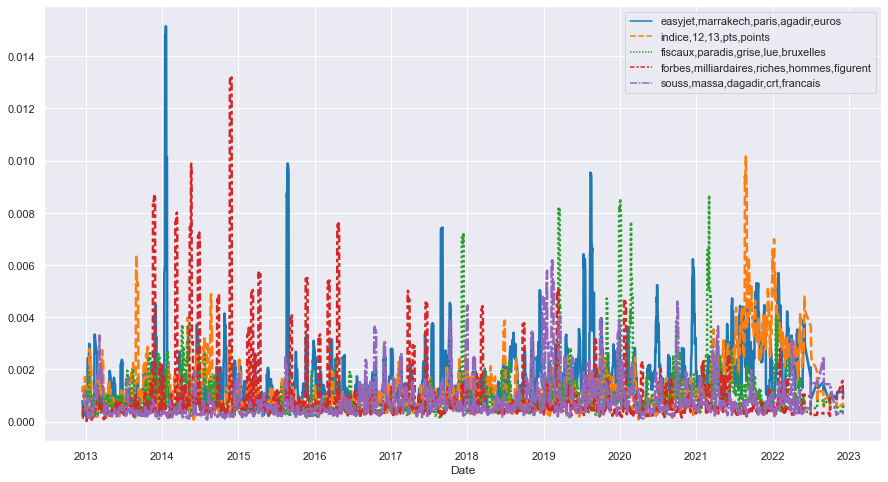

In [41]:
plt.figure(figsize=(15,8))
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=749251a5-b032-43b6-9ff6-da57d492ca8d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>